## Heart Failure Prediction Dataset

**Available at:** https://www.kaggle.com/fedesoriano/heart-failure-prediction

**Goals:** 
- treat the dataset to improve the prediction accuracy of heart failures
- predict heart failure

## Attribute Information
- **Age:** age of the patient [years]
- **Sex:** sex of the patient [M: Male, F: Female]
- **ChestPainType:** chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- **RestingBP:** resting blood pressure [mm Hg]
- **Cholesterol:** serum cholesterol [mm/dl]
- **FastingBS:** fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- **RestingECG:** resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- **MaxHR:** maximum heart rate achieved [Numeric value between 60 and 202]
- **ExerciseAngina:** exercise-induced angina [Y: Yes, N: No]
- **Oldpeak:** oldpeak = ST [Numeric value measured in depression]
- **ST_Slope:** the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- **HeartDisease:** output class [1: heart disease, 0: Normal]

In [1]:
import pandas as pd
import numpy as np
import sklearn as sk
import matplotlib.pyplot as plt
import seaborn as sns
import math
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

## Reading the Dataset

In [2]:
path = os.getcwd()

df = pd.read_csv(path + '\\heart.csv')
print(df.shape)
df.head()

(918, 12)


,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


## Exploring the Data

In [3]:
df.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


Outliers may be present, as in the cholesterol attribute (max = 603 with a mean of 198.8)

In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

There are no missing values

In [5]:
df[df.duplicated()]

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease


There are no duplicated values

### Checking the distributions of each attribute

In [6]:
for column in df.columns:
    print(column)

Age
Sex
ChestPainType
RestingBP
Cholesterol
FastingBS
RestingECG
MaxHR
ExerciseAngina
Oldpeak
ST_Slope
HeartDisease


In [7]:
def plot_dist(df):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

    nrows = 2
    ncols = 3
    fig, axs = plt.subplots(nrows=nrows, ncols=ncols)

    row = 0
    col = 0

    df_num = df.select_dtypes(include=numerics)
    for column in df_num.columns:
        k = math.ceil(5*np.log(len(df[column])))
        hist = df[column].plot.hist(ax=axs[row,col], bins=k)
        hist.set(xlabel=column)
        if col == 2:
            col = 0
            row += 1 
        else:
            col += 1

    fig.set_size_inches(18.5, 10.5)

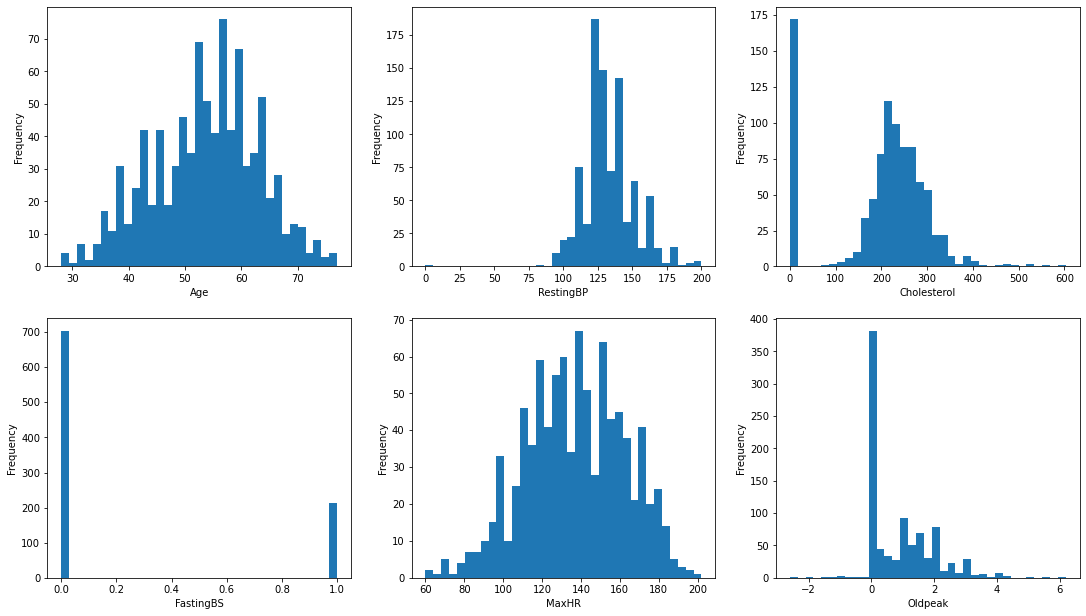

In [8]:
plot_dist(df.drop(columns='HeartDisease'))

As we can see, most of the variables, like 'Age', 'RestingBP', 'Cholesterol' and 'MaxHR', somewhat follow a normal distribution, while 'FastingBS' follows an Euler distribution and OldPeak is a bit odd. There are, however, some outliers in the dataset, that will be removed below.

### Splitting the Dataset into Training and Testing for Further Preprocessing

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop(columns='HeartDisease'), df['HeartDisease'], test_size=0.33)
print(f'x_train = {x_train.shape} \nx_test = {x_test.shape}')

x_train = (615, 11) 
x_test = (303, 11)


### Checking the correlation between the features and the target

<AxesSubplot:>

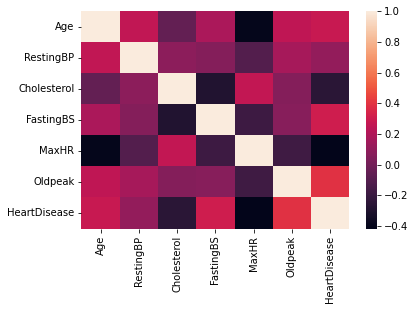

In [10]:
x_train = pd.merge(x_train, y_train, left_index=True, right_index=True)
columns = x_train._get_numeric_data().columns

corr = x_train[columns].corr()
x_train = x_train.drop(columns='HeartDisease')
sns.heatmap(corr)

In [11]:
corr

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
Age,1.000000,0.257753,-0.053944,0.185132,-0.401318,0.249162,0.276326
RestingBP,0.257753,1.000000,0.085872,0.058211,-0.111716,0.167894,0.106882
Cholesterol,-0.053944,0.085872,1.000000,-0.291077,0.260674,0.057979,-0.259317
FastingBS,0.185132,0.058211,-0.291077,1.000000,-0.184917,0.067449,0.304584
MaxHR,-0.401318,-0.111716,0.260674,-0.184917,1.000000,-0.179813,-0.416116
Oldpeak,0.249162,0.167894,0.057979,0.067449,-0.179813,1.000000,0.386469
HeartDisease,0.276326,0.106882,-0.259317,0.304584,-0.416116,0.386469,1.000000


As we can see, the variables with the strongest corerlations to the target are **Oldpeak, Age and FastingBS**. Those will be the ones used to train a base model, to which we'll compare our other models to

## Base Model (Logistic Regression)

This is a simplified model to set a base level from which we want to improve our prediction results

In [12]:
base_x_train = x_train[['Age', 'Oldpeak', 'FastingBS']]
base_x_test = x_test[['Age', 'Oldpeak', 'FastingBS']]

base_model = LogisticRegression()
base_model.fit(base_x_train, y_train)
base_pred = base_model.predict(base_x_test)

<AxesSubplot:>

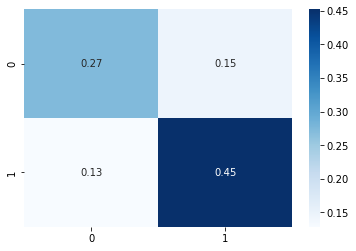

In [13]:
base_conf_mat = confusion_matrix(y_test, base_pred)
sns.heatmap(base_conf_mat/np.sum(base_conf_mat), annot=True, cmap='Blues')

In [14]:
base_f1 = f1_score(y_test, base_pred)
base_f1

0.7675070028011204

## Feature Engineering

### Encoding categorical variables with pandas OneHotEncoder 

In [15]:
x_train = pd.get_dummies(x_train)
x_test = pd.get_dummies(x_test)

In [16]:
x_train.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
704,50,150,243,0,128,2.6,0,1,1,0,0,0,1,0,0,1,0,0,1,0
310,65,155,0,0,154,1.0,0,1,1,0,0,0,0,1,0,1,0,0,0,1
607,53,144,300,1,128,1.5,0,1,1,0,0,0,0,0,1,0,1,0,1,0
394,57,160,0,1,98,2.0,0,1,1,0,0,0,0,1,0,0,1,0,1,0
99,41,125,269,0,144,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1


### Removing Outliers

In [17]:
cols = x_train.drop(columns='FastingBS')._get_numeric_data().columns # The "FastingBS" variable is a bool type

Q1 = x_train[cols].quantile(0.25)
Q3 = x_train[cols].quantile(0.75)
IQR = Q3 - Q1

x_train = pd.merge(x_train, y_train, left_index=True, right_index=True)
x_test = pd.merge(x_test, y_test, left_index=True, right_index=True)

x_train = x_train[~((x_train[cols] < (Q1 - 1.5*IQR)) | (x_train[cols] > (Q3 + 1.5*IQR)) ).any(axis=1)]
x_test = x_test[~((x_test[cols] < (Q1 - 1.5*IQR)) | (x_test[cols] > (Q3 + 1.5*IQR)) ).any(axis=1)]

y_train = x_train['HeartDisease']
y_test = x_test['HeartDisease']
x_train = x_train.drop(columns='HeartDisease')
x_test = x_test.drop(columns='HeartDisease')

x_train.describe()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.0,95.000000,95.000000,95.0,95.000000,95.000000
mean,51.294737,130.494737,234.105263,0.115789,131.494737,1.013684,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.431579,0.568421,0.0,0.726316,0.273684
std,8.437346,14.659159,62.108257,0.321670,22.961982,0.950432,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.497924,0.497924,0.0,0.448214,0.448214
min,35.000000,92.000000,85.000000,0.000000,87.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
25%,44.500000,120.000000,201.000000,0.000000,115.000000,0.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.000000
50%,52.000000,130.000000,230.000000,0.000000,130.000000,1.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.000000,1.000000,0.0,1.000000,0.000000
75%,57.000000,140.000000,263.500000,0.000000,149.000000,1.700000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000
max,75.000000,170.000000,412.000000,1.000000,181.000000,3.000000,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.000000,1.000000,0.0,1.000000,1.000000


Outliers removed by the quantiles method (values smaller than Q1 - 1.5\*IQR or greater than Q3 + 1.5\*IQR)

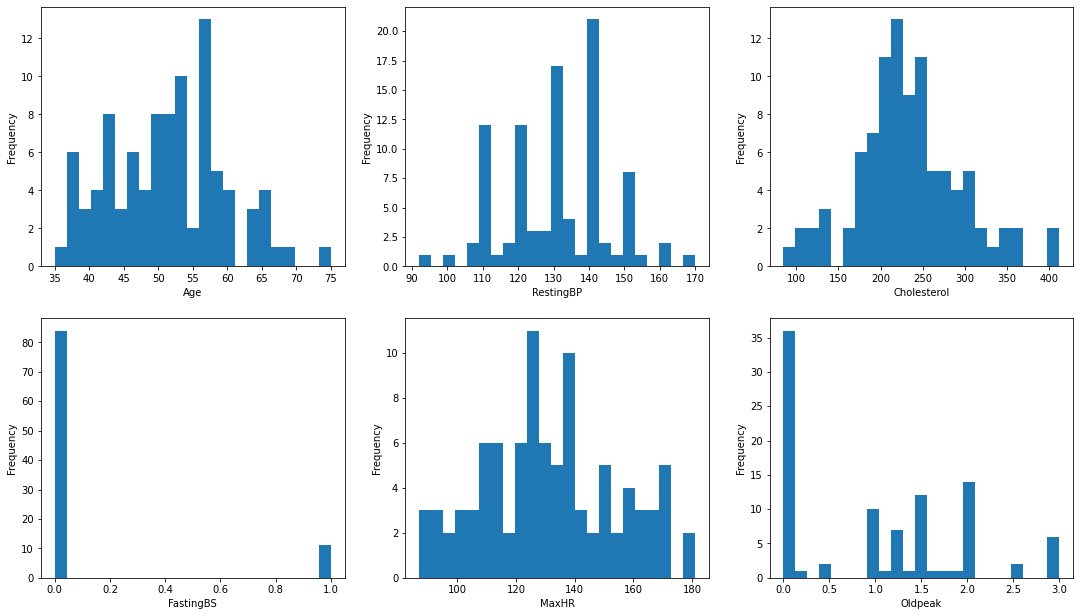

In [18]:
plot_dist(x_train)

Checking the distributions of x_train after removing the outliers.

## Feature Selection

<AxesSubplot:>

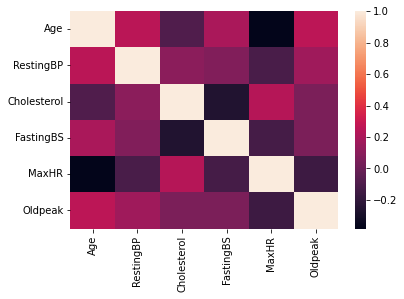

In [21]:
columns = df.drop(columns='HeartDisease')._get_numeric_data().columns

corr = df[columns].corr()
sns.heatmap(corr)

In [22]:
corr

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak
Age,1.000000,0.254399,-0.095282,0.198039,-0.382045,0.258612
RestingBP,0.254399,1.000000,0.100893,0.070193,-0.112135,0.164803
Cholesterol,-0.095282,0.100893,1.000000,-0.260974,0.235792,0.050148
FastingBS,0.198039,0.070193,-0.260974,1.000000,-0.131438,0.052698
MaxHR,-0.382045,-0.112135,0.235792,-0.131438,1.000000,-0.160691
Oldpeak,0.258612,0.164803,0.050148,0.052698,-0.160691,1.000000


There are no highly correlated features (> 90% correlation in this case), so none will be removed by this method.

## Prediction Models

### RandomForest Model

In [23]:
rf = RandomForestClassifier(n_estimators=1000, max_depth=10)
rf.fit(x_train, y_train)

RandomForestClassifier(max_depth=10, n_estimators=1000)

In [24]:
y_pred = rf.predict(x_test)

### Evaluating the Model

To evaluate the model, a confusion matrix and the f1 score metric will be used

<AxesSubplot:>

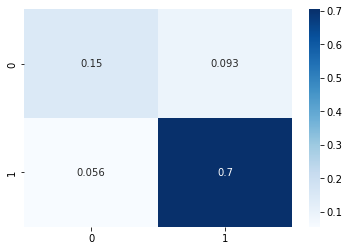

In [25]:
conf_mat = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, cmap='Blues')

In the confusion matrix:

\[true_negatives false_positives\]

\[false_negatives true_positives\]

In [28]:
f1_rf = f1_score(y_test, y_pred)
f1_rf

0.9047619047619047

- In comparison with the base model, the RandomForest used after some basic feature engineering and feature selection showed much better results, with an f1 score of 0.90, while the base model obtained an f1 score of 0.76. 
- The confusion matrix also shows that only around 15% of the predictions were wrong with the RandomForest model, while around 28% were misleading with the base model